<div>
<img src="./images/micron-flowchart.png" width="75%"/>
</div>

In [1]:
import os
import fsspec
import micron.datablocks

HOME = os.getenv('HOME')

In [2]:
DATALAKE = os.path.join(HOME, '.cache', 'datalake')

## miR expression profiles: miRCoHN
* miR counts for HNSC (Head-and-Neck Squamous Cell Carcinoma)
* Downloadable from [https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/HNSC/20160128](https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/HNSC/20160128).

#### study of clustering of miR *expression profile cluster* shows correlation with stromal/epithelial miR downregulation:
See [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7854517/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7854517/) including supplements.

#### build a local miRCoHN dataset

In [3]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.miRLogCoHN@mirlogcohn'
mirlogcohn = micron.datablocks.miRLogCoHN(
	roots=f'{DATALAKE}/DBX/micron/datablocks/miRLogCoHN/mirlogcohn/revision={micron.datablocks.miRLogCoHN.REVISION}',
	verbose=True,
)

mirlogcohn.build()

>>> miRLogCoHN: Already built.  Done.


In [4]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.miRCoHN@mircohn'
mircohn = micron.datablocks.miRCoHN(
	roots=	{
		'logcounts': f'{DATALAKE}/DBX/micron/datablocks/miRCoHN/mircohn/revision={micron.datablocks.miRCoHN.REVISION}/logcounts',
		'counts': f'{DATALAKE}/DBX/micron/datablocks/miRCoHN/mircohn/revision={micron.datablocks.miRCoHN.REVISION}/counts',
		'logcontrols': f'{DATALAKE}/DBX/micron/datablocks/miRCoHN/mircohn/revision={micron.datablocks.miRCoHN.REVISION}/logcontrols',
		'controls': f'{DATALAKE}/DBX/micron/datablocks/miRCoHN/mircohn/revision={micron.datablocks.miRCoHN.REVISION}/controls',
		'seq_patterns': f'{DATALAKE}/DBX/micron/datablocks/miRCoHN/mircohn/revision={micron.datablocks.miRCoHN.REVISION}/seq_patterns',
		'pivots': f'{DATALAKE}/DBX/micron/datablocks/miRCoHN/mircohn/revision={micron.datablocks.miRCoHN.REVISION}/pivots',
		},
	scope=micron.datablocks.miRCoHN.SCOPE(
		logcounts=mirlogcohn.read(),
	),
	verbose=True,
)

mircohn.build()

>>> miRLogCoHN: Reading topic 'miRLogCoHN'
>>> miRCoHN: All topics built already.  Done.


{'logcounts': '/Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/miRCoHN/mircohn/revision=1.2.1/logcounts/mircohn_rpm_log2.parquet',
 'counts': '/Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/miRCoHN/mircohn/revision=1.2.1/counts/mircohn_rpm.parquet',
 'logcontrols': '/Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/miRCoHN/mircohn/revision=1.2.1/logcontrols/mircohn_logcontrols.parquet',
 'controls': '/Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/miRCoHN/mircohn/revision=1.2.1/controls/mircohn_ontrols.parquet',
 'seq_patterns': '/Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/miRCoHN/mircohn/revision=1.2.1/seq_patterns/seq_patterns.parquet',
 'pivots': '/Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/miRCoHN/mircohn/revision=1.2.1/pivots/mircohn_pivots.parquet'}

#### miRCoHN summary
* Counts data contains 2588 named miR sequence (cols)
    * This is > than the number of characterized human miR sequences from mirnabase.org (below)
* There are 488 patient records (rows), all from tumor containing tissue
    * Additionally, there are 44 controls or normal tissue counts

## Clustering of miRCoHN expression profiles data
* Cluster vectors in the 2588-dim space
* Analogous to BOW (bag-of-words) data
    * Each seq is a "word"
    * Along with the log number (per million) of its occurrences in the "document" -- tissue record

<div>
<img src="./images/histogram-embedding-1.png" width="75%"/>
</div>

#### `logcounts` clusters

In [5]:
%%time
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.ZSCC@zscc_mircohn_logcounts'
zscc_mircohn_logcounts = micron.datablocks.ZSCC(
	roots=	{
		'zscc': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision={micron.datablocks.ZSCC.REVISION}/zscc',
		'clusters': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision={micron.datablocks.ZSCC.REVISION}/clusters',
		'ordering': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision={micron.datablocks.ZSCC.REVISION}/ordering',
		},
	scope=micron.datablocks.ZSCC.SCOPE(
		data_frame=mircohn.read('logcounts'),
		fillna=0.0,
	),
	verbose=True,
)

zscc_mircohn_logcounts.build()


>>> miRCoHN: Reading topic 'logcounts'
>>> ZSCC: ZSCC already built
>>> ZSCC: ... done
CPU times: user 145 ms, sys: 54.6 ms, total: 200 ms
Wall time: 83.4 ms


<div>
<img src="./images/histogram-embedding-n.png" width="75%"/>
</div>

#### display clustered miRCoHN data using UMAP (cluster assignments are color-coded)

#### `zscc` contains information about clustering, including the optimal number of clusters found
* In our case it is 2

In [6]:
display(len(zscc_mircohn_logcounts.read("clusters")) - zscc_mircohn_logcounts.read("clusters").sum()) # cluster 0 size
display(zscc_mircohn_logcounts.read("clusters").sum()) # cluster 1 size

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision=0.8.1/clusters/clusters.parquet
Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision=0.8.1/clusters/clusters.parquet


clusters    288
dtype: int64

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision=0.8.1/clusters/clusters.parquet


clusters    200
dtype: int64

>>> miRCoHN: Reading topic 'logcounts'
Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision=0.8.1/clusters/clusters.parquet


/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


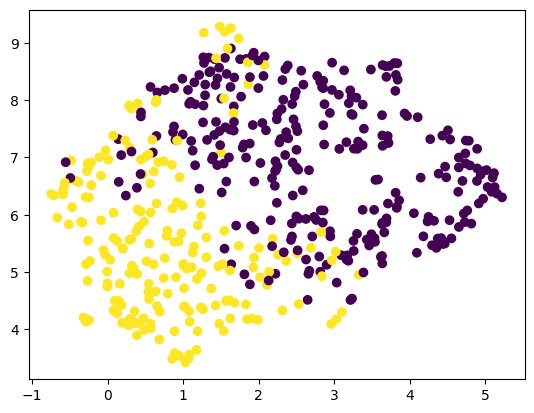

In [7]:
micron.datablocks.ZSCC.display_umap(mircohn.read('logcounts'), color=zscc_mircohn_logcounts.read('clusters').clusters)

#### display `logcounts` heatmap
* after subtracting mean control expressions
* restricting columns to sequences downregulated in epithelial/stromal histologies

>>> miRCoHN: Reading topic 'logcounts'
>>> miRCoHN: Reading topic 'logcontrols'
Read zscc cluster ordering from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision=0.8.1/ordering/ordering.pkl


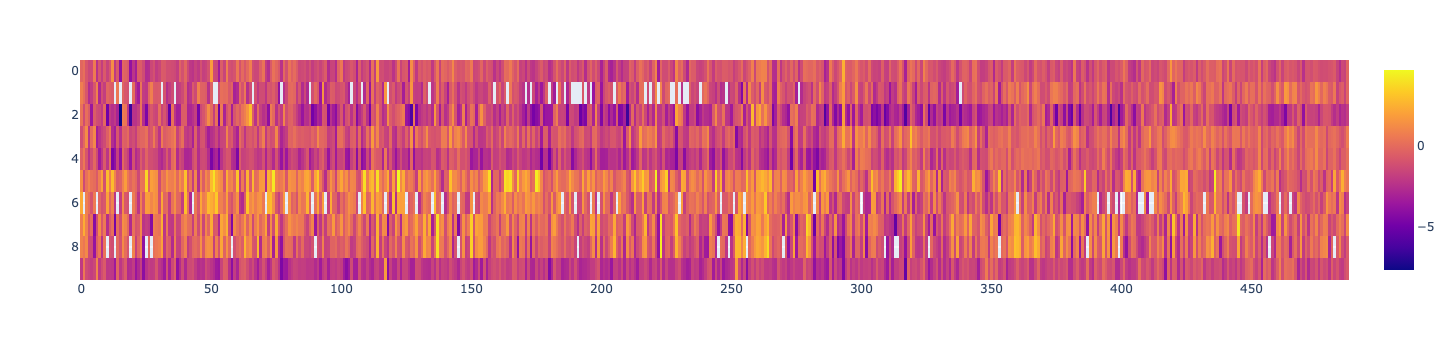

In [8]:
# There should be a discernible change left-to-right around the size of cluster 0
micron.datablocks.miRCoHN.display_heatmap(mircohn.read('logcounts'), 
                                          seq_mad_threshold=0.99, 
                                          center_at_controls=mircohn.read('logcontrols'), 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['epithelial'], 
                                          ordering=zscc_mircohn_logcounts.read('ordering'), 
                                          nseqs=10)

>>> miRCoHN: Reading topic 'logcounts'
>>> miRCoHN: Reading topic 'logcontrols'
Read zscc cluster ordering from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision=0.8.1/ordering/ordering.pkl


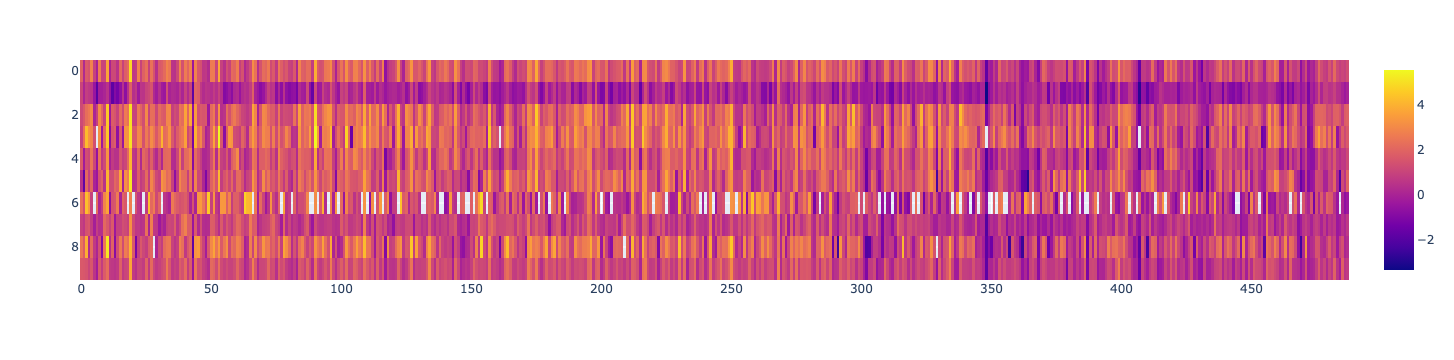

In [9]:
# There should be a discernible change left-to-right around the size of cluster 0
micron.datablocks.miRCoHN.display_heatmap(mircohn.read('logcounts'), 
                                          seq_mad_threshold=0.99, 
                                          center_at_controls=mircohn.read('logcontrols'), 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['stromal'], 
                                          ordering=zscc_mircohn_logcounts.read('ordering'), 
                                          nseqs=10)

#### `counts` clusters

In [10]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.ZSCC@zscc_mircohn_counts'
zscc_mircohn_counts = micron.datablocks.ZSCC(
	roots=	{
		'zscc': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision={micron.datablocks.ZSCC.REVISION}/zscc',
		'clusters': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision={micron.datablocks.ZSCC.REVISION}/clusters',
		'ordering': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision={micron.datablocks.ZSCC.REVISION}/ordering',
		},
	scope=micron.datablocks.ZSCC.SCOPE(
		data_frame=mircohn.read('counts'),
		fillna=0.0,
	),
	verbose=True,
)

zscc_mircohn_counts.build()

>>> miRCoHN: Reading topic 'counts'
>>> ZSCC: ZSCC already built
>>> ZSCC: ... done


In [11]:
display(len(zscc_mircohn_counts.read("clusters")) - zscc_mircohn_counts.read("clusters").sum()) # cluster 0 size
display(zscc_mircohn_counts.read("clusters").sum()) # cluster 1 size

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision=0.8.1/clusters/clusters.parquet
Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision=0.8.1/clusters/clusters.parquet


clusters    341
dtype: int64

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision=0.8.1/clusters/clusters.parquet


clusters    147
dtype: int64

>>> miRCoHN: Reading topic 'counts'
Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision=0.8.1/clusters/clusters.parquet


/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



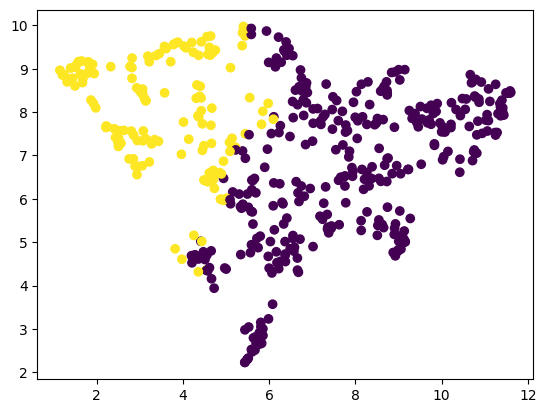

In [12]:
micron.datablocks.ZSCC.display_umap(mircohn.read('counts'), color=zscc_mircohn_counts.read('clusters').clusters)

#### display `counts` heatmap
* after subtracting mean control expressions
* restricting columns to sequences downregulated in epithelial/stromal histologies

>>> miRCoHN: Reading topic 'logcounts'
>>> miRCoHN: Reading topic 'logcontrols'
Read zscc cluster ordering from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision=0.8.1/ordering/ordering.pkl


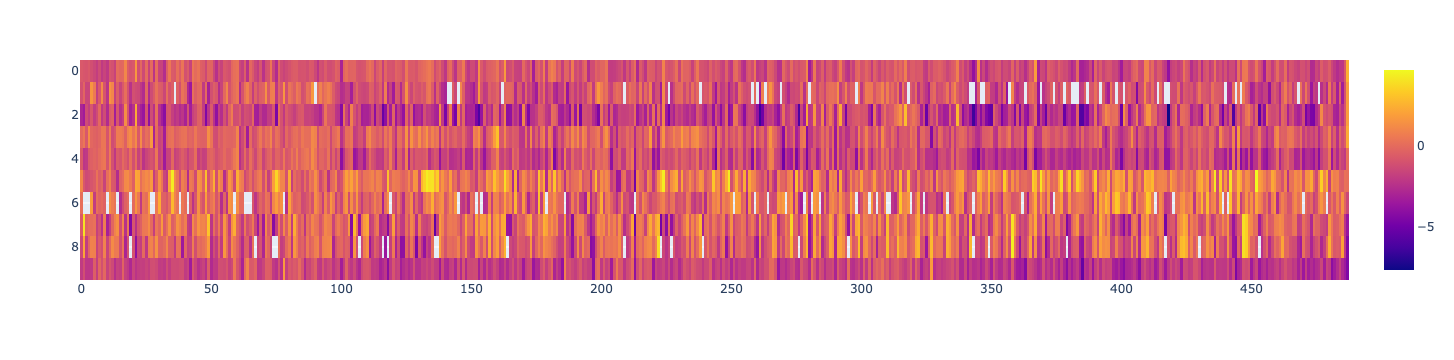

In [13]:
# There should be a discernible change left-to-right around the size of cluster 0
micron.datablocks.miRCoHN.display_heatmap(mircohn.read('logcounts'), 
                                          seq_mad_threshold=0.99, 
                                          center_at_controls=mircohn.read('logcontrols'), 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['epithelial'], 
                                          ordering=zscc_mircohn_counts.read('ordering'), 
                                          nseqs=10)

>>> miRCoHN: Reading topic 'logcounts'
>>> miRCoHN: Reading topic 'logcontrols'
Read zscc cluster ordering from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision=0.8.1/ordering/ordering.pkl


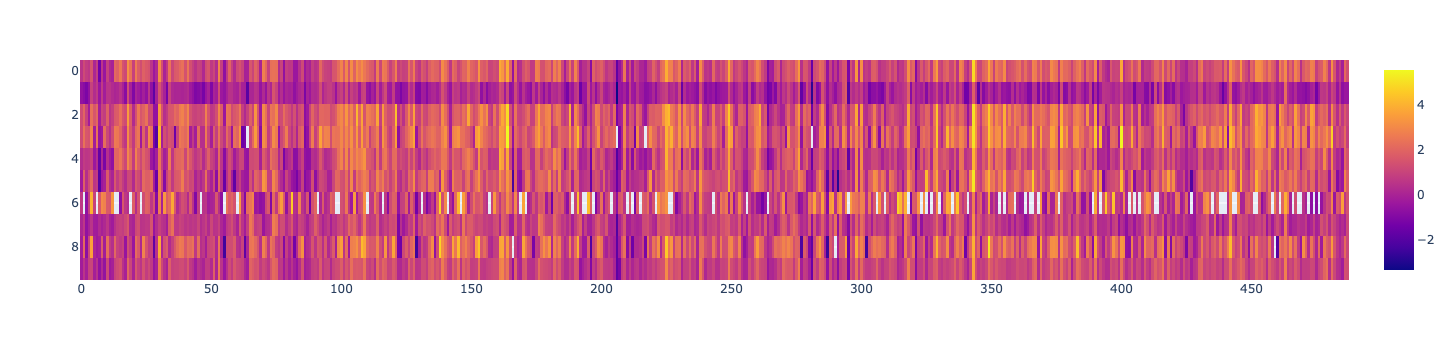

In [14]:
# There should be a discernible change left-to-right around the size of cluster 0
micron.datablocks.miRCoHN.display_heatmap(mircohn.read('logcounts'), 
                                          seq_mad_threshold=0.99, 
                                          center_at_controls=mircohn.read('logcontrols'), 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['stromal'], 
                                          ordering=zscc_mircohn_counts.read('ordering'), 
                                          nseqs=10)

## miRNA sequenses
#### aka miRSeqs
* downloadable from ["https://mirbase.org/download"]("https://mirbase.org/download")

In [15]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.miRNA@mirna'
mirna = micron.datablocks.miRNA(
	roots=f'{DATALAKE}/DBX/micron/datablocks/miRNA/mirna/revision={micron.datablocks.miRNA.REVISION}',
	verbose=True,
)

mirna.build()

>>> miRNA: miRNA already built in root /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/miRNA/mirna/revision=0.3.1


In [16]:
mirnaseqs = mirna.read()
display(mirnaseqs.shape)
display(mirnaseqs.head())

(1917, 3)

ID  Accession                                           sequence
0  hsa-let-7a-1  MI0000060  UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...
1  hsa-let-7a-2  MI0000061  AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGA...
2  hsa-let-7a-3  MI0000062  GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGG...
3    hsa-let-7b  MI0000063  CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCC...
4    hsa-let-7c  MI0000064  GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCU...

## miRCoSeqs: 

#### seqs x counts: 
* seqs sampled according to counts
* there are different numbers of seqs in miRCo (2588) and mirSeqs (1917)

#### sequence ID mismatch

#### one solution
- form the "join" or intersection of sequences based on the numeric part of the second component of their IDs:
For example, miRSeq `hsa-let-7a-2	MI0000061` is mapped to `0000061`, which is then matched to the miRCo seq with the second component of ID of the form `xxxxx0000061`
 
- obtain 229 joint seqs (jseqs)
- IDs are mapped back the miRCo seq IDs
- `jlogcounts` and `jlogcontrols` are miRCo records restricted to the jseqs


In [17]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.miRCoSeqs@mircoseqshn_1000_300'
mircoseqshn_1000_300 = micron.datablocks.miRCoSeqs(
	roots=	{
		'logcounts': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1000_300/revision={micron.datablocks.miRCoSeqs.REVISION}/logcounts',
		'counts': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1000_300/revision={micron.datablocks.miRCoSeqs.REVISION}/counts',
		'logcontrols': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1000_300/revision={micron.datablocks.miRCoSeqs.REVISION}/logcontrols',
		'controls': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1000_300/revision={micron.datablocks.miRCoSeqs.REVISION}/controls',
		'seqs': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1000_300/revision={micron.datablocks.miRCoSeqs.REVISION}/seqs',
		'samples': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1000_300/revision={micron.datablocks.miRCoSeqs.REVISION}/samples',
		'rec_sample_ranges': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1000_300/revision={micron.datablocks.miRCoSeqs.REVISION}/rec_sample_ranges',
		},
	scope=micron.datablocks.miRCoSeqs.SCOPE(
		logcounts=mircohn.read('logcounts'),
		logcontrols=mircohn.read('logcontrols'),
		seqs=mirna.read(),
		npasses=1000,
		nseqs_per_record=300,
	),
	verbose=True,
)

mircoseqshn_1000_300.build()

>>> miRCoHN: Reading topic 'logcounts'
>>> miRCoHN: Reading topic 'logcontrols'
>>> miRCoSeqs: miRCoSeqs already built
>>> miRCoSeqs: ... done


## miRCoSeqsHN jclustering
#### Are restricted counts clusters aligned with downregulation?

#### test `jlogcount` against `jlogcontrols`, restricted to `epithelial` and `stromal` downregulated seqs

In [18]:
jlogcounts = mircoseqshn_1000_300.read('logcounts')
jlogcontrols = mircoseqshn_1000_300.read(topic='logcontrols')

#### `jlogcounts` clustering

In [19]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.ZSCC@zscc_mircoseqshn_logcounts'
zscc_mircoseqshn_logcounts = micron.datablocks.ZSCC(
	roots=	{
		'zscc': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_logcounts/revision={micron.datablocks.ZSCC.REVISION}/zscc',
		'clusters': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_logcounts/revision={micron.datablocks.ZSCC.REVISION}/clusters',
		'ordering': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_logcounts/revision={micron.datablocks.ZSCC.REVISION}/ordering',
		},
	scope=micron.datablocks.ZSCC.SCOPE(
		data_frame=mircoseqshn_1000_300.read('logcounts'),
		fillna=0.0,
	),
	verbose=True,
)

zscc_mircoseqshn_logcounts.build()

>>> ZSCC: ZSCC already built
>>> ZSCC: ... done


In [20]:
zscc_mircoseqshn_logcounts_clusters = zscc_mircoseqshn_logcounts.read("clusters").clusters
zscc_mircoseqshn_logcounts_ordering = zscc_mircoseqshn_logcounts.read("ordering")
display(len(zscc_mircoseqshn_logcounts_clusters) - zscc_mircoseqshn_logcounts_clusters.sum())
display(zscc_mircoseqshn_logcounts_clusters.sum())

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_logcounts/revision=0.8.1/clusters/clusters.parquet
Read zscc cluster ordering from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_logcounts/revision=0.8.1/ordering/ordering.pkl


221

267

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



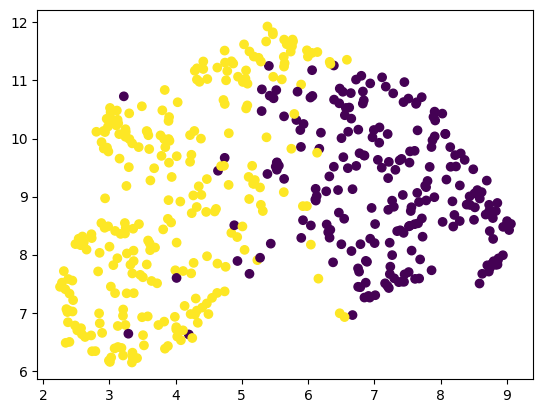

In [21]:
micron.datablocks.ZSCC.display_umap(mircoseqshn_1000_300.read('logcounts'), color=zscc_mircoseqshn_logcounts_clusters)

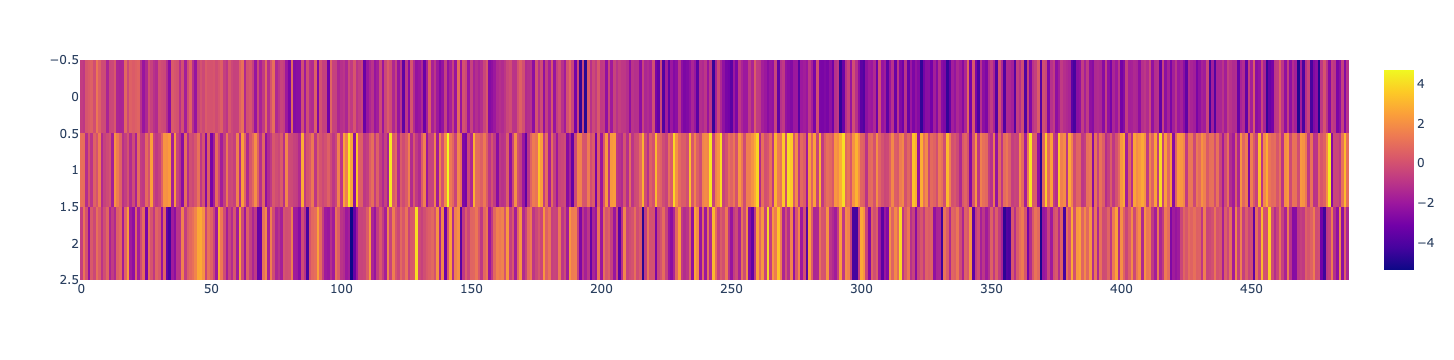

In [22]:
micron.datablocks.miRCoHN.display_heatmap(mircoseqshn_1000_300.read('logcounts'), 
                                          seq_mad_threshold=0.9, 
                                          center_at_controls=mircoseqshn_1000_300.read('logcontrols'), 
                                          ordering=zscc_mircoseqshn_logcounts_ordering, 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['epithelial'],)

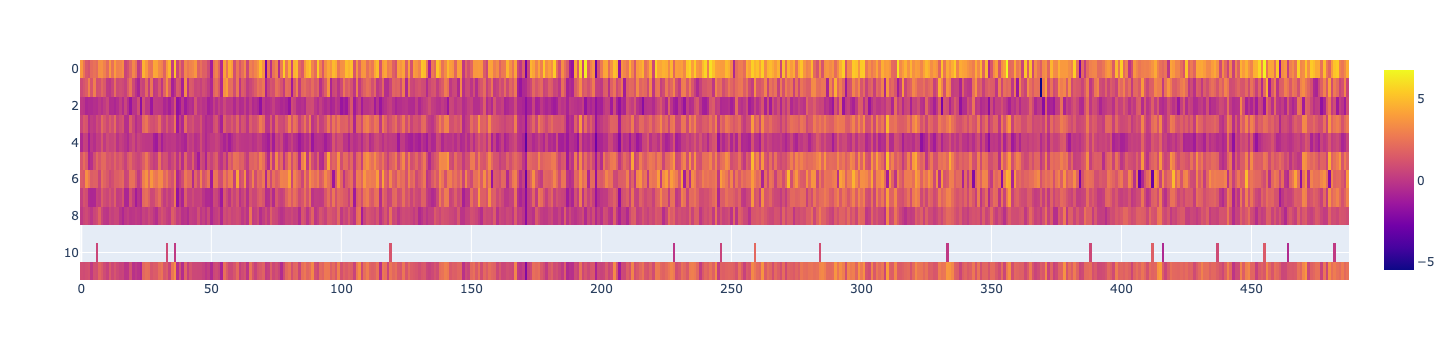

In [23]:
micron.datablocks.miRCoHN.display_heatmap(mircoseqshn_1000_300.read('logcounts'), 
                                          seq_mad_threshold=0.9, 
                                          center_at_controls=mircoseqshn_1000_300.read('logcontrols'), 
                                          ordering=zscc_mircoseqshn_logcounts_ordering, 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['stromal'],)

#### `jcounts` clustering

In [24]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.ZSCC@zscc_mircoseqshn_counts'
zscc_mircoseqshn_counts = micron.datablocks.ZSCC(
	roots=	{
		'zscc': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_counts/revision={micron.datablocks.ZSCC.REVISION}/zscc',
		'clusters': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_counts/revision={micron.datablocks.ZSCC.REVISION}/clusters',
		'ordering': f'{DATALAKE}/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_counts/revision={micron.datablocks.ZSCC.REVISION}/ordering',
		},
	scope=micron.datablocks.ZSCC.SCOPE(
		data_frame=mircoseqshn_1000_300.read('counts'),
		fillna=0.0,
	),
	verbose=True,
)

zscc_mircoseqshn_counts.build()

>>> ZSCC: ZSCC already built
>>> ZSCC: ... done


In [25]:
zscc_mircoseqshn_counts_clusters = zscc_mircoseqshn_counts.read("clusters").clusters
zscc_mircoseqshn_counts_ordering = zscc_mircoseqshn_counts.read("ordering")
display(len(zscc_mircoseqshn_counts_clusters) - zscc_mircoseqshn_counts_clusters.sum())
display(zscc_mircoseqshn_counts_clusters.sum())

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_counts/revision=0.8.1/clusters/clusters.parquet
Read zscc cluster ordering from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircoseqshn_counts/revision=0.8.1/ordering/ordering.pkl


305

183

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



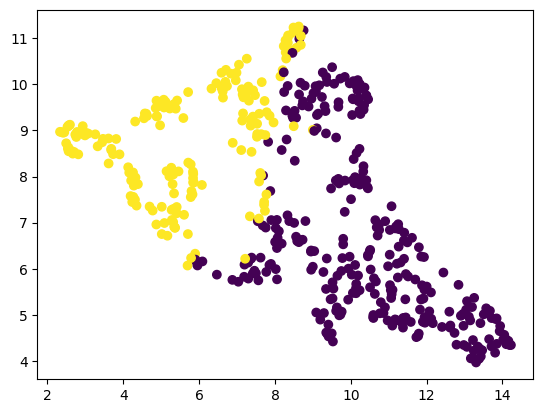

In [26]:
micron.datablocks.ZSCC.display_umap(mircoseqshn_1000_300.read('counts'), color=zscc_mircoseqshn_counts_clusters)

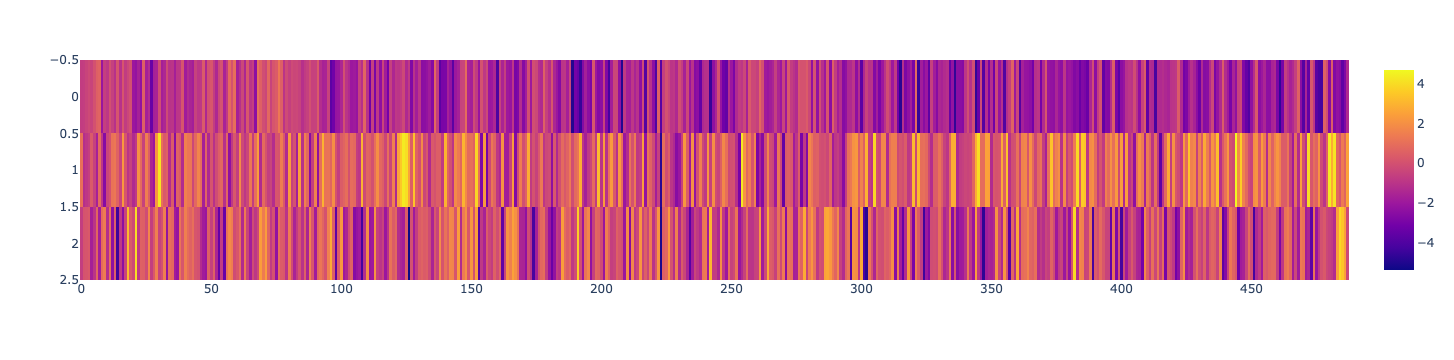

In [27]:
micron.datablocks.miRCoHN.display_heatmap(mircoseqshn_1000_300.read('logcounts'), 
                                          seq_mad_threshold=0.9, 
                                          center_at_controls=mircoseqshn_1000_300.read('logcontrols'), 
                                          ordering=zscc_mircoseqshn_counts_ordering, 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['epithelial'],)

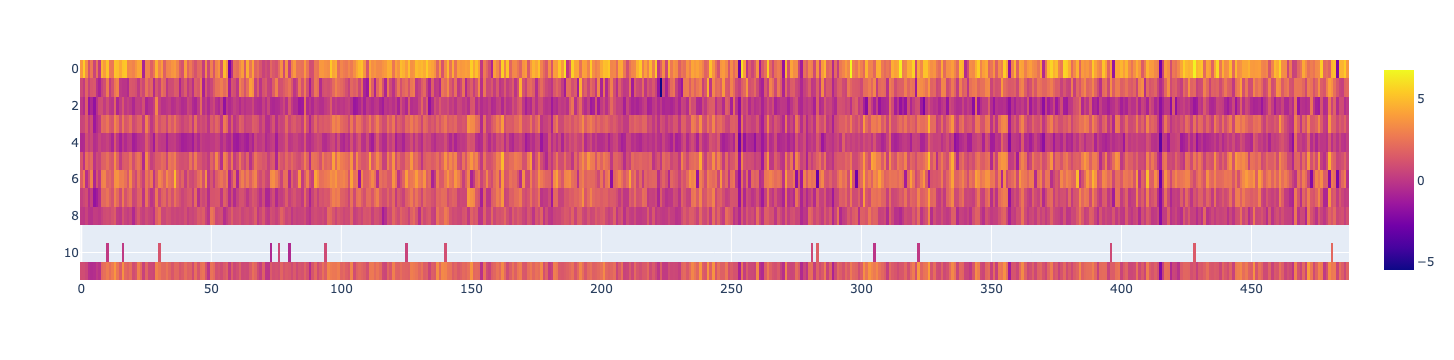

In [28]:
micron.datablocks.miRCoHN.display_heatmap(mircoseqshn_1000_300.read('logcounts'), 
                                          seq_mad_threshold=0.9, 
                                          center_at_controls=mircoseqshn_1000_300.read('logcontrols'), 
                                          ordering=zscc_mircoseqshn_counts_ordering, 
                                          seq_patterns=micron.datablocks.miRCoHN.SEQ_PATTERNS['stromal'],)

## Seq embedding: FastText
#### Minimize a cross-entropy reconstruction loss 
* mapping words to vectors
* based on the word's context
<div>
<img src="./images/fasttext-cbow.png" width="65%"/>
</div>

#### miR seqs sampled according to miRCo
* Restricted to `jseqs`
* For miR the context is invariant to rearrangements
* determined only by co-expressed miR sequences
* with probability derived from joint expression frequences

#### Training
* Taking 1000 passes through all exponentiated `jcount` records
* Generating 300 multinomial seq samples according to each record's frequencies
* Each 300-seq "bag" is a FastText context

#### Testing
* 1 pass
* Concatenate all 300 embedding vectors for each record into a single 300000-dim vector
* Visualizing with `umap` using `jlogcount` cluster assignments

<div>
<img src="./images/histogram-seq-fasttext-embedding.png" width="75%"/>
</div>

In [29]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.FastText@microseqshn_cbow'
microseqshn_cbow = micron.datablocks.FastText(
	roots=f'{DATALAKE}/DBX/micron/datablocks/FastText/microseqshn_cbow/revision={micron.datablocks.FastText.REVISION}',
	scope=micron.datablocks.FastText.SCOPE(
		samples_path=mircoseqshn_1000_300.roots['samples'],
		model='cbow',
		dim=100,
		context_window_size=300,
	),
	verbose=True,
)

microseqshn_cbow.build()

>>> FastText: 'cbow' already built


In [30]:
cbow = microseqshn_cbow.read()

#### Using single pass jseq samples to generate record embeddings

In [31]:
import fsspec
import micron.datablocks


# 'DBX.micron.datablocks.miRCoSeqs@mircoseqshn_1_300'
mircoseqshn_1_300 = micron.datablocks.miRCoSeqs(
	roots=	{
		'logcounts': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1_300/revision={micron.datablocks.miRCoSeqs.REVISION}/logcounts',
		'counts': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1_300/revision={micron.datablocks.miRCoSeqs.REVISION}/counts',
		'logcontrols': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1_300/revision={micron.datablocks.miRCoSeqs.REVISION}/logcontrols',
		'controls': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1_300/revision={micron.datablocks.miRCoSeqs.REVISION}/controls',
		'seqs': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1_300/revision={micron.datablocks.miRCoSeqs.REVISION}/seqs',
		'samples': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1_300/revision={micron.datablocks.miRCoSeqs.REVISION}/samples',
		'rec_sample_ranges': f'{DATALAKE}/DBX/micron/datablocks/miRCoSeqs/mircoseqshn_1_300/revision={micron.datablocks.miRCoSeqs.REVISION}/rec_sample_ranges',
		},
	scope=micron.datablocks.miRCoSeqs.SCOPE(
		logcounts=mircohn.read('logcounts'),
		logcontrols=mircohn.read('logcontrols'),
		seqs=mirna.read(),
		npasses=1,
		nseqs_per_record=300,
	),
	verbose=True,
)

mircoseqshn_1_300.build()

>>> miRCoHN: Reading topic 'logcounts'
>>> miRCoHN: Reading topic 'logcontrols'
>>> miRCoSeqs: miRCoSeqs already built
>>> miRCoSeqs: ... done


#### Concatenate

In [32]:
import numpy as np
mircoseqshn_1_300_samples = mircoseqshn_1_300.read('samples')
mircoseqshn_1_300_rec_sample_ranges = mircoseqshn_1_300.read('rec_sample_ranges')
cbowsamples_ = np.array([[cbow[sample] for sample in mircoseqshn_1_300_samples[r[0]:r[1]]] for r in mircoseqshn_1_300_rec_sample_ranges.iloc[:, 0]])
shape_ = cbowsamples_.shape
cbowsamples = cbowsamples_.reshape(shape_[0], shape_[-2]*shape_[-1])
cbowsamples.shape

>>> miRCoSeqs: Read 146401 useqs


(488, 30000)

#### umap of `cbow` embeddings colored by `jlogcount` clusters

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



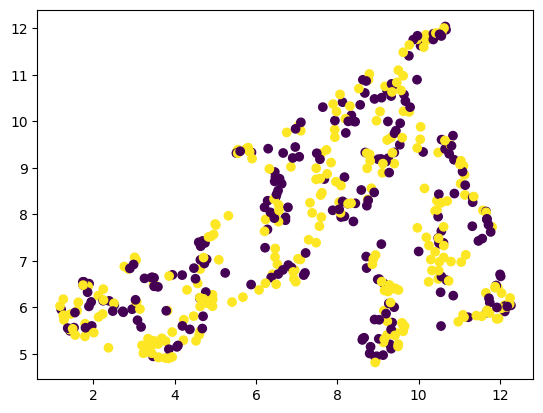

In [33]:
import pandas as pd
micron.datablocks.FastText.display_umap(pd.DataFrame(cbowsamples), color=zscc_mircoseqshn_logcounts_clusters)

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



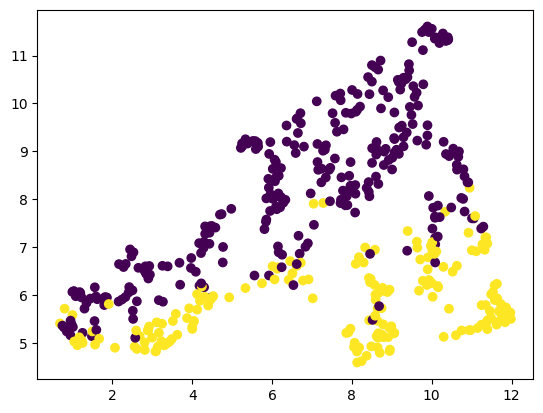

In [34]:
import pandas as pd
micron.datablocks.FastText.display_umap(pd.DataFrame(cbowsamples), color=zscc_mircoseqshn_counts_clusters)

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_logcounts/revision=0.8.1/clusters/clusters.parquet


/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



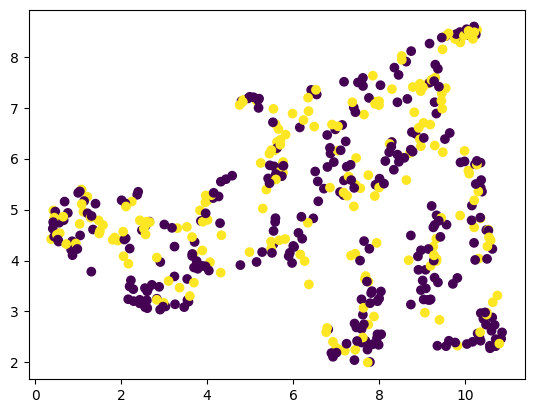

In [35]:
import pandas as pd
micron.datablocks.FastText.display_umap(pd.DataFrame(cbowsamples), color=zscc_mircohn_logcounts.read('clusters').clusters)

Read zscc clusters from /Users/dkarpeyev/.cache/datalake/DBX/micron/datablocks/ZSCC/zscc_mircohn_counts/revision=0.8.1/clusters/clusters.parquet


/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/dkarpeyev/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



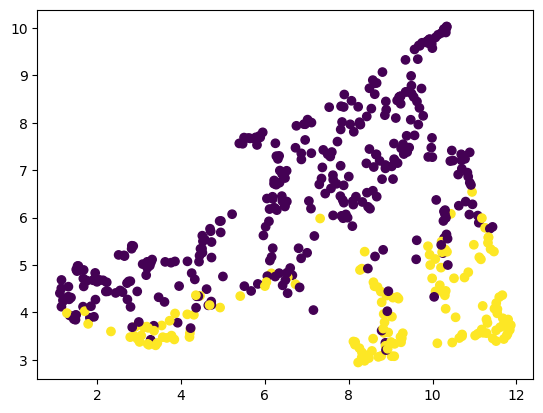

In [36]:
import pandas as pd
micron.datablocks.FastText.display_umap(pd.DataFrame(cbowsamples), color=zscc_mircohn_counts.read('clusters').clusters)